# Model Training - Sub model 3

## Load the Dataset 3

In [ ]:
import pandas as pd

ATB_LTB = pd.read_csv(r'..\..\Datasets\train\balanced\ATB_LTB.csv')

## Separate features and target

In [2]:
# Separate features and target in each dataset

X_ATB_LTB = ATB_LTB.drop(columns=['TB_Status'])
y_ATB_LTB = ATB_LTB['TB_Status']

## Training the model using best algorithm

In [3]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [4]:
selected_features_path = r"..\..\Saved_files\selected_features_ATB_LTB.csv"
model_save_path = r"..\..\Saved_files\best_sub_model_3.pkl"

# Load selected features
selected_features = pd.read_csv(selected_features_path)
selected_feature_names = selected_features['Selected Features'].tolist()
X_ATB_LTB = X_ATB_LTB[selected_feature_names]

# Split data
X_train_TB_Stage, X_test_TB_Stage, y_train_TB_Stage, y_test_TB_Stage = train_test_split(
    X_ATB_LTB, y_ATB_LTB, test_size=0.2, random_state=42
)

# Feature selection using Extra Trees Classifier
feature_selector = SelectFromModel(ExtraTreesClassifier(random_state=42), threshold="mean")
X_train_selected = feature_selector.fit_transform(X_train_TB_Stage, y_train_TB_Stage)
X_test_selected = feature_selector.transform(X_test_TB_Stage)

# ✅ Get selected feature names
selected_mask = feature_selector.get_support()
selected_feature_names_final = np.array(selected_feature_names)[selected_mask]

# Display selected feature information
print("\n" + "="*60)
print("🔍 FEATURE SELECTION RESULTS (Extra Trees Classifier - Sub Model 3)")
print("="*60)
print(f"Total features before selection : {len(selected_feature_names)}")
print(f"Total features after selection  : {len(selected_feature_names_final)}\n")
print("Selected Features:")
for i, feature in enumerate(selected_feature_names_final, start=1):
    print(f"{i}. {feature}")
print("="*60 + "\n")

# Save feature selector
feature_selector_TB_Stage_path = r"..\..\Saved_files\feature_selector_TB_Stage.pkl"
with open(feature_selector_TB_Stage_path, 'wb') as file:
    pickle.dump(feature_selector, file)

# Label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_TB_Stage)
y_test_encoded = label_encoder.transform(y_test_TB_Stage)

# Save label encoder
label_encoder_TB_Stage_path = r"..\..\Saved_files\label_encoder_TB_Stage.pkl"
with open(label_encoder_TB_Stage_path, 'wb') as file:
    pickle.dump(label_encoder, file)

# Define TB stage labels
tb_stage_labels = ["Active TB", "Latent TB"]

print(f"Training set shape: {X_train_selected.shape}")
print(f"Test set shape: {X_test_selected.shape}")
print(f"Class distribution in training: {dict(zip(tb_stage_labels, np.bincount(y_train_encoded)))}")



🔍 FEATURE SELECTION RESULTS (Extra Trees Classifier - Sub Model 3)
Total features before selection : 10
Total features after selection  : 6

Selected Features:
1. ILMN_1776939
2. ILMN_1691071
3. ILMN_1678730
4. ILMN_2302757
5. ILMN_2114568
6. ILMN_1713454

Training set shape: (288, 6)
Test set shape: (72, 6)
Class distribution in training: {'Active TB': 142, 'Latent TB': 146}


In [5]:
# --- Create Optimized Random Forest Pipeline (Sub-Model 3: TB_Stage) ---
best_model_TB_Stage = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        random_state=42,
        n_estimators=200,       # Increased estimators for better learning
        max_depth=None,         # Allow full growth unless stopped by other params
        min_samples_split=3,    # Fine-tuned for generalization
        min_samples_leaf=1,
        max_features='sqrt',
        oob_score=True,
        class_weight=None,
        n_jobs=-1
    )
)

# --- Cross-validation for performance validation ---
print("Performing 5-fold Stratified Cross-Validation...\n")
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_idx, val_idx in stratified_cv.split(X_train_selected, y_train_encoded):
    X_train_fold, X_val_fold = X_train_selected[train_idx], X_train_selected[val_idx]
    y_train_fold, y_val_fold = y_train_encoded[train_idx], y_train_encoded[val_idx]
    best_model_TB_Stage.fit(X_train_fold, y_train_fold)
    y_val_pred = best_model_TB_Stage.predict(X_val_fold)
    score = f1_score(y_val_fold, y_val_pred, average='weighted')
    cv_scores.append(score)

print("Cross-validation F1 scores:", cv_scores)
print("Mean CV F1 Score:", np.mean(cv_scores))

# --- Incremental Training with Early Stopping based on OOB Score ---
print("\nPerforming incremental training with early stopping based on OOB score...\n")
prev_oob_score = 0
best_n_estimators = 200

for i in range(15):  # More iterations for fine-tuning
    best_model_TB_Stage.named_steps['randomforestclassifier'].n_estimators += 15
    best_model_TB_Stage.fit(X_train_selected, y_train_encoded)
    curr_oob_score = best_model_TB_Stage.named_steps['randomforestclassifier'].oob_score_
    print(f"Iteration {i+1}: n_estimators = {best_model_TB_Stage.named_steps['randomforestclassifier'].n_estimators}, OOB Score = {curr_oob_score:.4f}")
    
    if curr_oob_score <= prev_oob_score:  # Stop if OOB score stops improving
        print("\nEarly stopping triggered — OOB score stopped improving.")
        best_model_TB_Stage.named_steps['randomforestclassifier'].n_estimators = best_n_estimators
        break
    prev_oob_score = curr_oob_score
    best_n_estimators = best_model_TB_Stage.named_steps['randomforestclassifier'].n_estimators

# --- Evaluate on Test Set ---
y_pred_best_TB_Stage = best_model_TB_Stage.predict(X_test_selected)
y_pred_proba = best_model_TB_Stage.named_steps['randomforestclassifier'].predict_proba(X_test_selected)

print("\n" + "="*60)
print("SUB-MODEL 3 (TB_STAGE) - OPTIMIZED RANDOM FOREST PERFORMANCE")
print("="*60)

# --- Detailed classification report ---
print("\nBest TB_Stage Classification Report:")
print(classification_report(y_test_encoded, y_pred_best_TB_Stage, target_names=tb_stage_labels))

# --- Overall metrics ---
accuracy = accuracy_score(y_test_encoded, y_pred_best_TB_Stage)
precision = precision_score(y_test_encoded, y_pred_best_TB_Stage, average='weighted')
recall = recall_score(y_test_encoded, y_pred_best_TB_Stage, average='weighted')
f1 = f1_score(y_test_encoded, y_pred_best_TB_Stage, average='weighted')

print(f"\nOverall Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# --- Class-wise metrics ---
print(f"\nClass-wise Performance:")
for i, label in enumerate(tb_stage_labels):
    class_precision = precision_score(y_test_encoded, y_pred_best_TB_Stage, average=None)[i]
    class_recall = recall_score(y_test_encoded, y_pred_best_TB_Stage, average=None)[i]
    class_f1 = f1_score(y_test_encoded, y_pred_best_TB_Stage, average=None)[i]
    print(f"{label:20} - Precision: {class_precision:.4f}, Recall: {class_recall:.4f}, F1: {class_f1:.4f}")

# --- Save the Trained Model ---
model_save_path = r"..\..\Saved_files\best_sub_model_3.pkl"
with open(model_save_path, 'wb') as file:
    pickle.dump(best_model_TB_Stage, file)

print(f"\n✅ Trained model saved to {model_save_path}")


Performing 5-fold Stratified Cross-Validation...

Cross-validation F1 scores: [0.8446888329307775, 0.9137674695212608, 0.8792744573297651, 0.8068986024382991, 0.9473684210526315]
Mean CV F1 Score: 0.8783995566545467

Performing incremental training with early stopping based on OOB score...

Iteration 1: n_estimators = 215, OOB Score = 0.8854
Iteration 2: n_estimators = 230, OOB Score = 0.8889
Iteration 3: n_estimators = 245, OOB Score = 0.8924
Iteration 4: n_estimators = 260, OOB Score = 0.8958
Iteration 5: n_estimators = 275, OOB Score = 0.8924

Early stopping triggered — OOB score stopped improving.

SUB-MODEL 3 (TB_STAGE) - OPTIMIZED RANDOM FOREST PERFORMANCE

Best TB_Stage Classification Report:
              precision    recall  f1-score   support

   Active TB       0.91      0.79      0.85        38
   Latent TB       0.79      0.91      0.85        34

    accuracy                           0.85        72
   macro avg       0.85      0.85      0.85        72
weighted avg       

In [6]:
# Extract the scaler correctly
scaler_TB_Stage = best_model_TB_Stage.named_steps['standardscaler']  # Use 'standardscaler' 

# Define path to save the scaler
scaler_save_path_TB_Stage = r"..\..\Saved_files\scalar\scaler_TB_Stage.pkl"

# Save the scaler
with open(scaler_save_path_TB_Stage, 'wb') as file:
    pickle.dump(scaler_TB_Stage, file)

print(f"Scaler for TB Type saved to {scaler_save_path_TB_Stage}")


Scaler for TB Type saved to ..\..\Saved_files\scalar\scaler_TB_Stage.pkl


## Evaluation of the sub model

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate the model and display metrics
def evaluate_model(y_true, y_pred, label):
    print(f"\n--- Evaluation Metrics for {label} ---")
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("\n")

    # Display confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_true), yticklabels=set(y_true))
    plt.title(f'Confusion Matrix for {label}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


--- Model Evaluation ---

--- Evaluation Metrics for TB_Stage ---
Accuracy: 0.85
Precision: 0.86
Recall: 0.85
F1 Score: 0.85




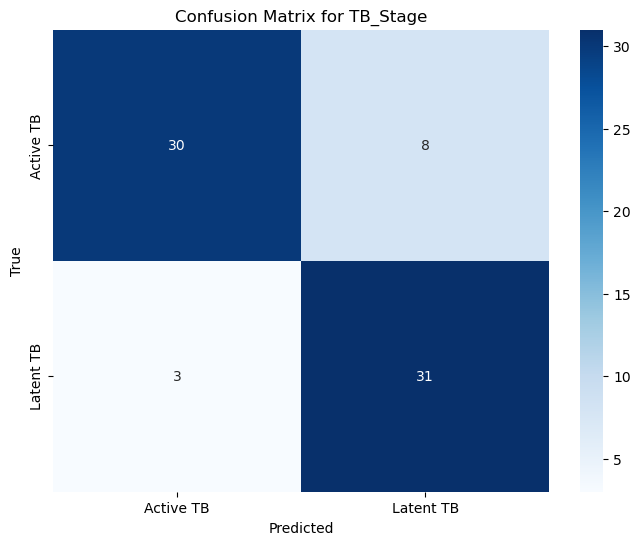

In [8]:
# Evaluate models using test datasets
print("\n--- Model Evaluation ---")
# TB_Stage Evaluation using the best model
y_pred_TB_Stage = best_model_TB_Stage.predict(X_test_selected)

# Convert encoded predictions back to text labels
y_test_labels = label_encoder.inverse_transform(y_test_encoded)
y_pred_labels = label_encoder.inverse_transform(y_pred_TB_Stage)

# Evaluate using original labels
evaluate_model(y_test_labels, y_pred_labels, "TB_Stage")

